This guide will show you how to use Multivariate (many features) Time Series data to predict future demand. You’ll learn how to preprocess and scale the data. And you’re going to build a Bidirectional LSTM Neural Network to make the predictions.

Here are the steps you’ll take:

* Data
* Feature Engineering
* Exploration
* Preprocessing
* Predicting Demand
* Evaluation

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from pandas.plotting import register_matplotlib_converters

%matplotlib inline
%config InlineBackend.figure_format='retina'

register_matplotlib_converters()
sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 22, 10

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [3]:
data = pd.read_csv('london_merged.csv')
data.head()

,timestamp,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season
0,2015-01-04 00:00:00,182,3.0,2.0,93.0,6.0,3.0,0.0,1.0,3.0
1,2015-01-04 01:00:00,138,3.0,2.5,93.0,5.0,1.0,0.0,1.0,3.0
2,2015-01-04 02:00:00,134,2.5,2.5,96.5,0.0,1.0,0.0,1.0,3.0
3,2015-01-04 03:00:00,72,2.0,2.0,100.0,0.0,1.0,0.0,1.0,3.0
4,2015-01-04 04:00:00,47,2.0,0.0,93.0,6.5,1.0,0.0,1.0,3.0


In [10]:
data.shape

(17414, 10)

In [6]:
df = pd.read_csv(
  "london_merged.csv",
  parse_dates=['timestamp'],
  index_col="timestamp"
)
df.head()

,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season
timestamp,,,,,,,,,
2015-01-04 00:00:00,182,3.0,2.0,93.0,6.0,3.0,0.0,1.0,3.0
2015-01-04 01:00:00,138,3.0,2.5,93.0,5.0,1.0,0.0,1.0,3.0
2015-01-04 02:00:00,134,2.5,2.5,96.5,0.0,1.0,0.0,1.0,3.0
2015-01-04 03:00:00,72,2.0,2.0,100.0,0.0,1.0,0.0,1.0,3.0
2015-01-04 04:00:00,47,2.0,0.0,93.0,6.5,1.0,0.0,1.0,3.0


In [7]:
df.describe()

,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season
count,17414.000000,17414.000000,17414.000000,17414.000000,17414.000000,17414.000000,17414.000000,17414.000000,17414.000000
mean,1143.101642,12.468091,11.520836,72.324954,15.913063,2.722752,0.022051,0.285403,1.492075
std,1085.108068,5.571818,6.615145,14.313186,7.894570,2.341163,0.146854,0.451619,1.118911
min,0.000000,-1.500000,-6.000000,20.500000,0.000000,1.000000,0.000000,0.000000,0.000000
25%,257.000000,8.000000,6.000000,63.000000,10.000000,1.000000,0.000000,0.000000,0.000000
50%,844.000000,12.500000,12.500000,74.500000,15.000000,2.000000,0.000000,0.000000,1.000000
75%,1671.750000,16.000000,16.000000,83.000000,20.500000,3.000000,0.000000,1.000000,2.000000
max,7860.000000,34.000000,34.000000,100.000000,56.500000,26.000000,1.000000,1.000000,3.000000


In [9]:
df.shape

(17414, 9)

That might do. What features do we have?

* timestamp - timestamp field for grouping the data
* cnt - the count of a new bike shares
* t1 - real temperature in C
* t2 - temperature in C “feels like”
* hum - humidity in percentage
* wind_speed - wind speed in km/h
* weather_code - category of the weather
* is_holiday - boolean field - 1 holiday / 0 non holiday
* is_weekend - boolean field - 1 if the day is weekend
* season - category field meteorological seasons: 0-spring ; 1-summer; 2-fall; 3-winter.

**How well can we predict future demand based on the data?**

# Feature Engineering


In [11]:
df['hour'] = df.index.hour
df['day_of_month'] = df.index.day
df['day_of_week'] = df.index.dayofweek
df['month'] = df.index.month

In [12]:
df.head()

,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season,hour,day_of_month,day_of_week,month
timestamp,,,,,,,,,,,,,
2015-01-04 00:00:00,182,3.0,2.0,93.0,6.0,3.0,0.0,1.0,3.0,0,4,6,1
2015-01-04 01:00:00,138,3.0,2.5,93.0,5.0,1.0,0.0,1.0,3.0,1,4,6,1
2015-01-04 02:00:00,134,2.5,2.5,96.5,0.0,1.0,0.0,1.0,3.0,2,4,6,1
2015-01-04 03:00:00,72,2.0,2.0,100.0,0.0,1.0,0.0,1.0,3.0,3,4,6,1
2015-01-04 04:00:00,47,2.0,0.0,93.0,6.5,1.0,0.0,1.0,3.0,4,4,6,1


# Exploration

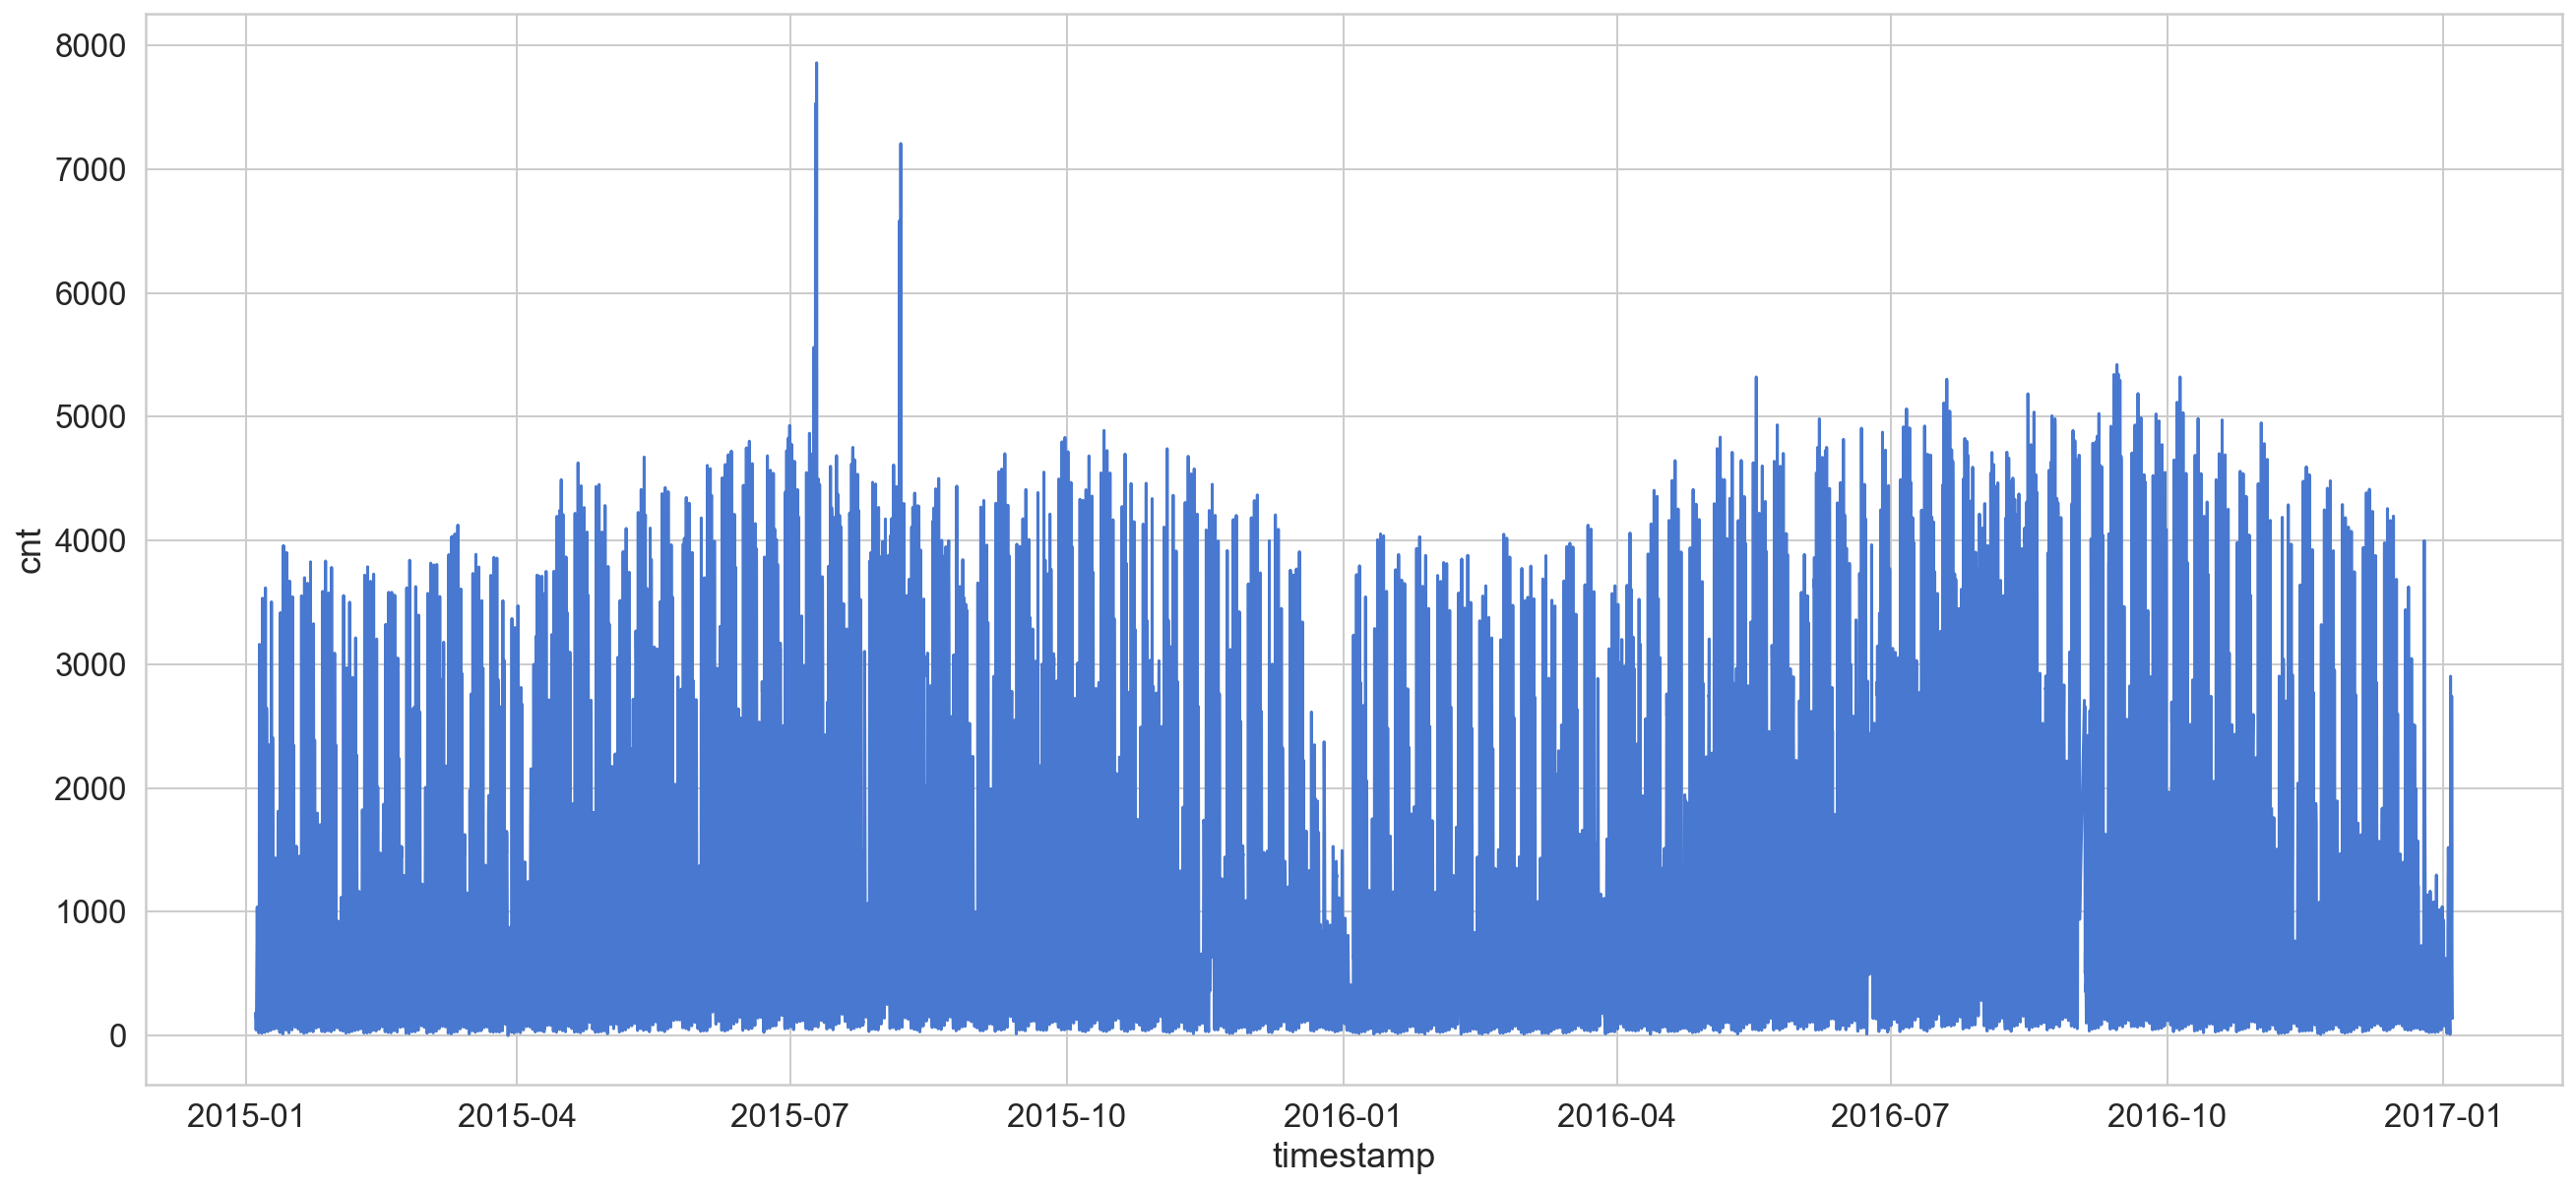

In [13]:
sns.lineplot(x=df.index, y="cnt", data=df);

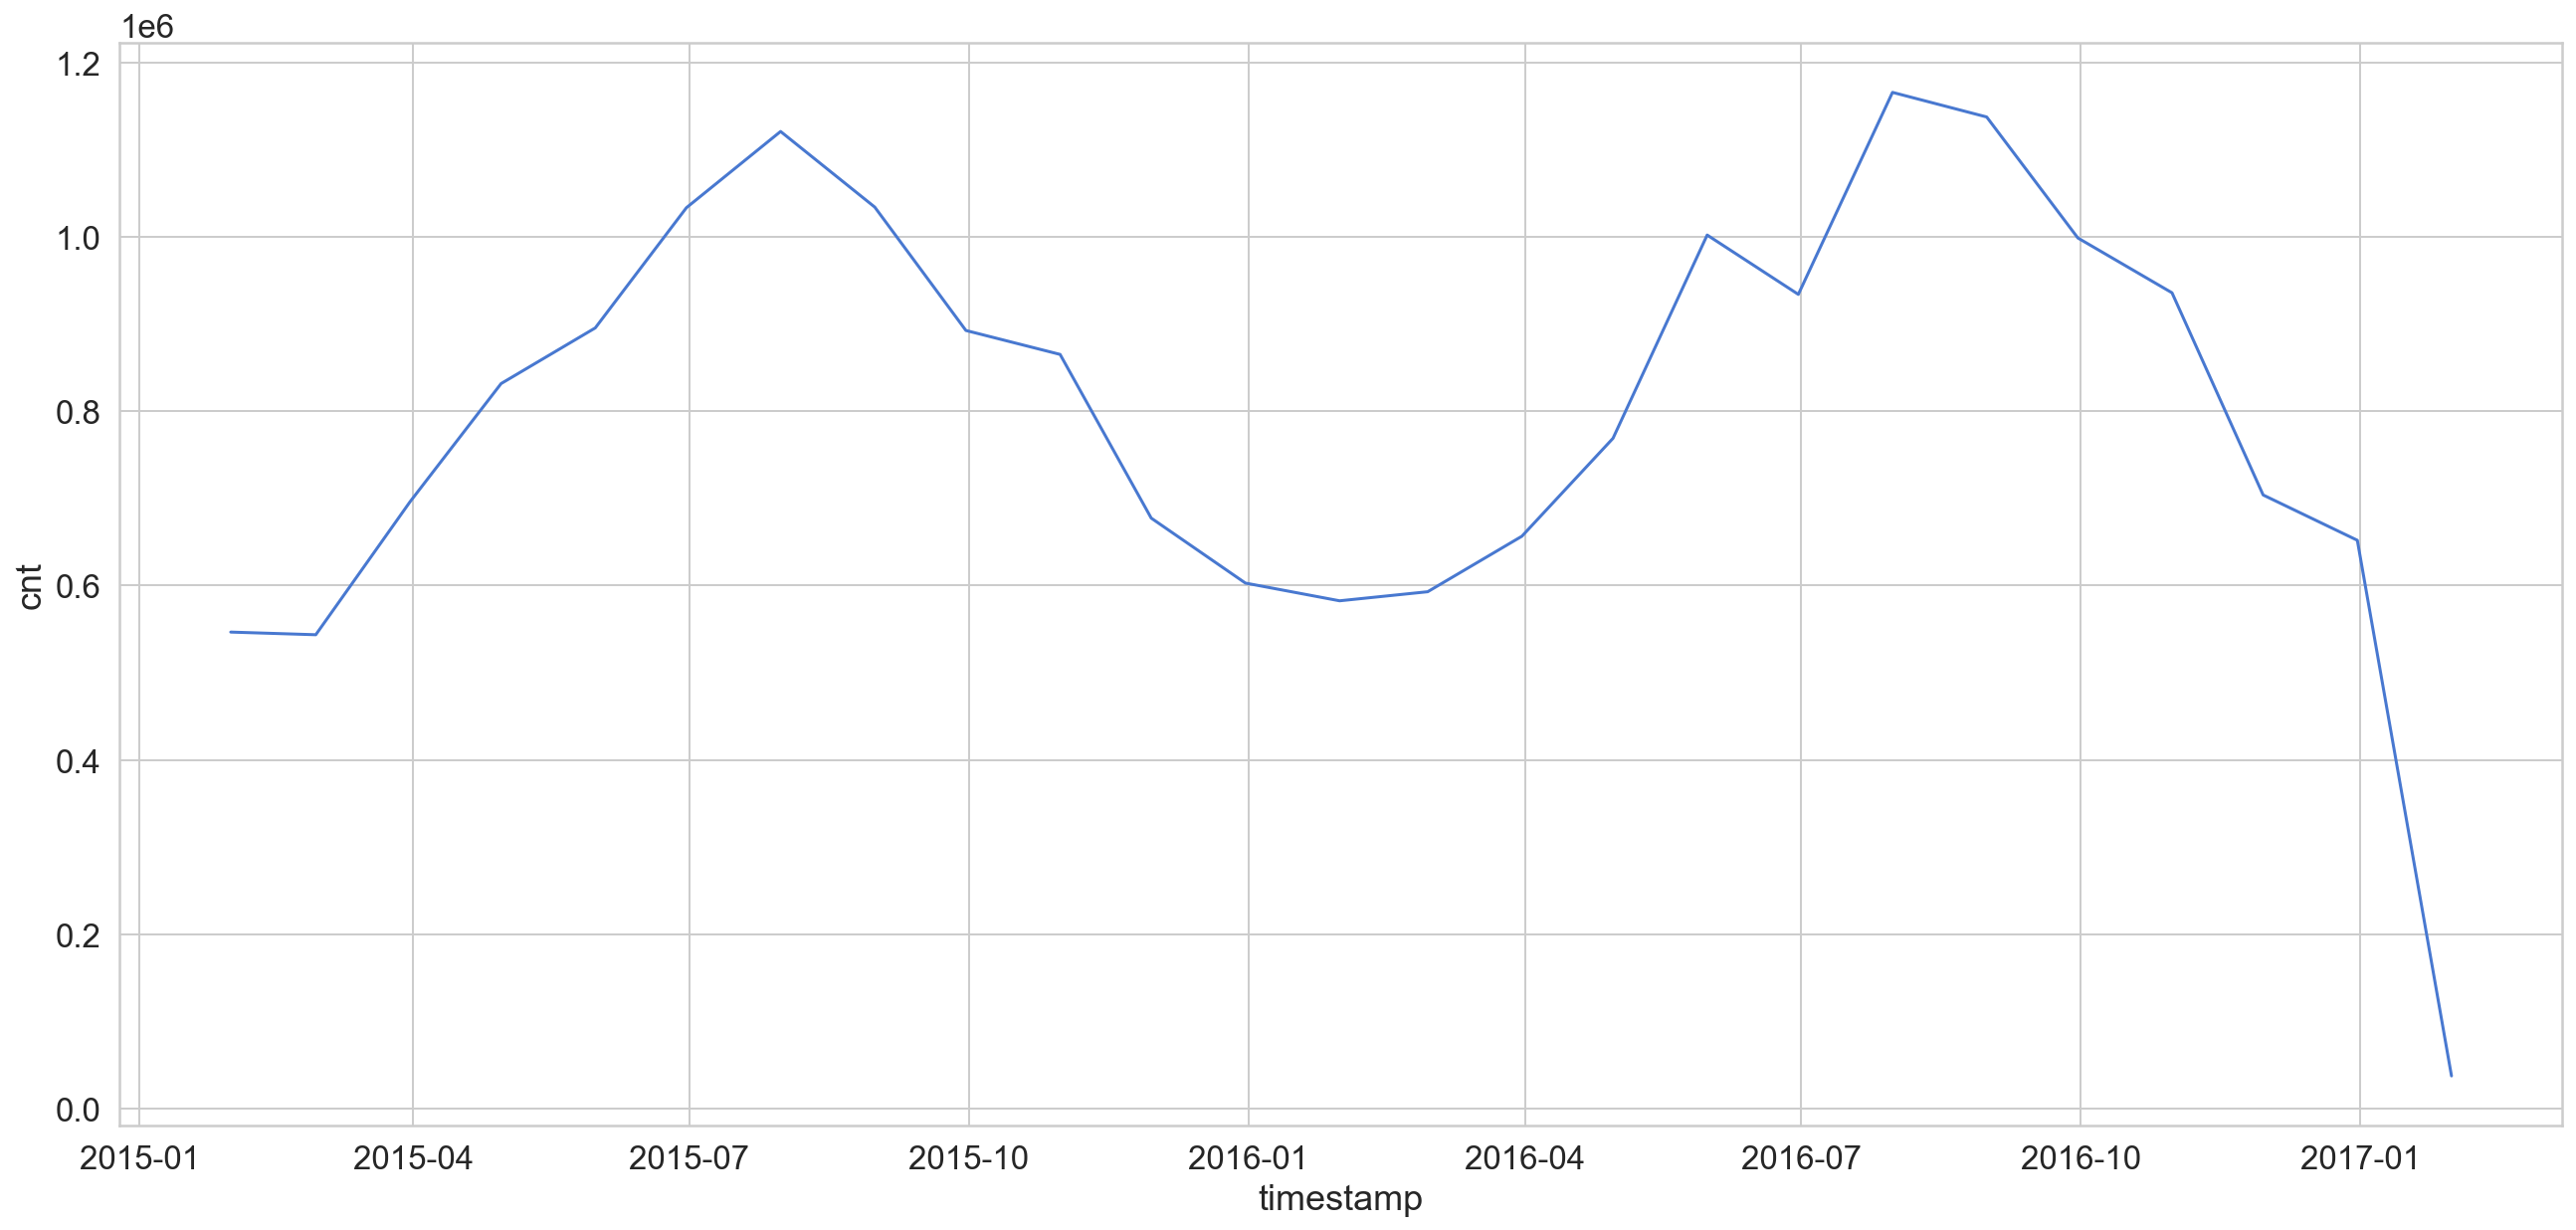

In [14]:
df_by_month = df.resample('M').sum()

sns.lineplot(x=df_by_month.index, y="cnt", data=df_by_month);

Our data seems to have a strong seasonality component. Summer months are good for business.

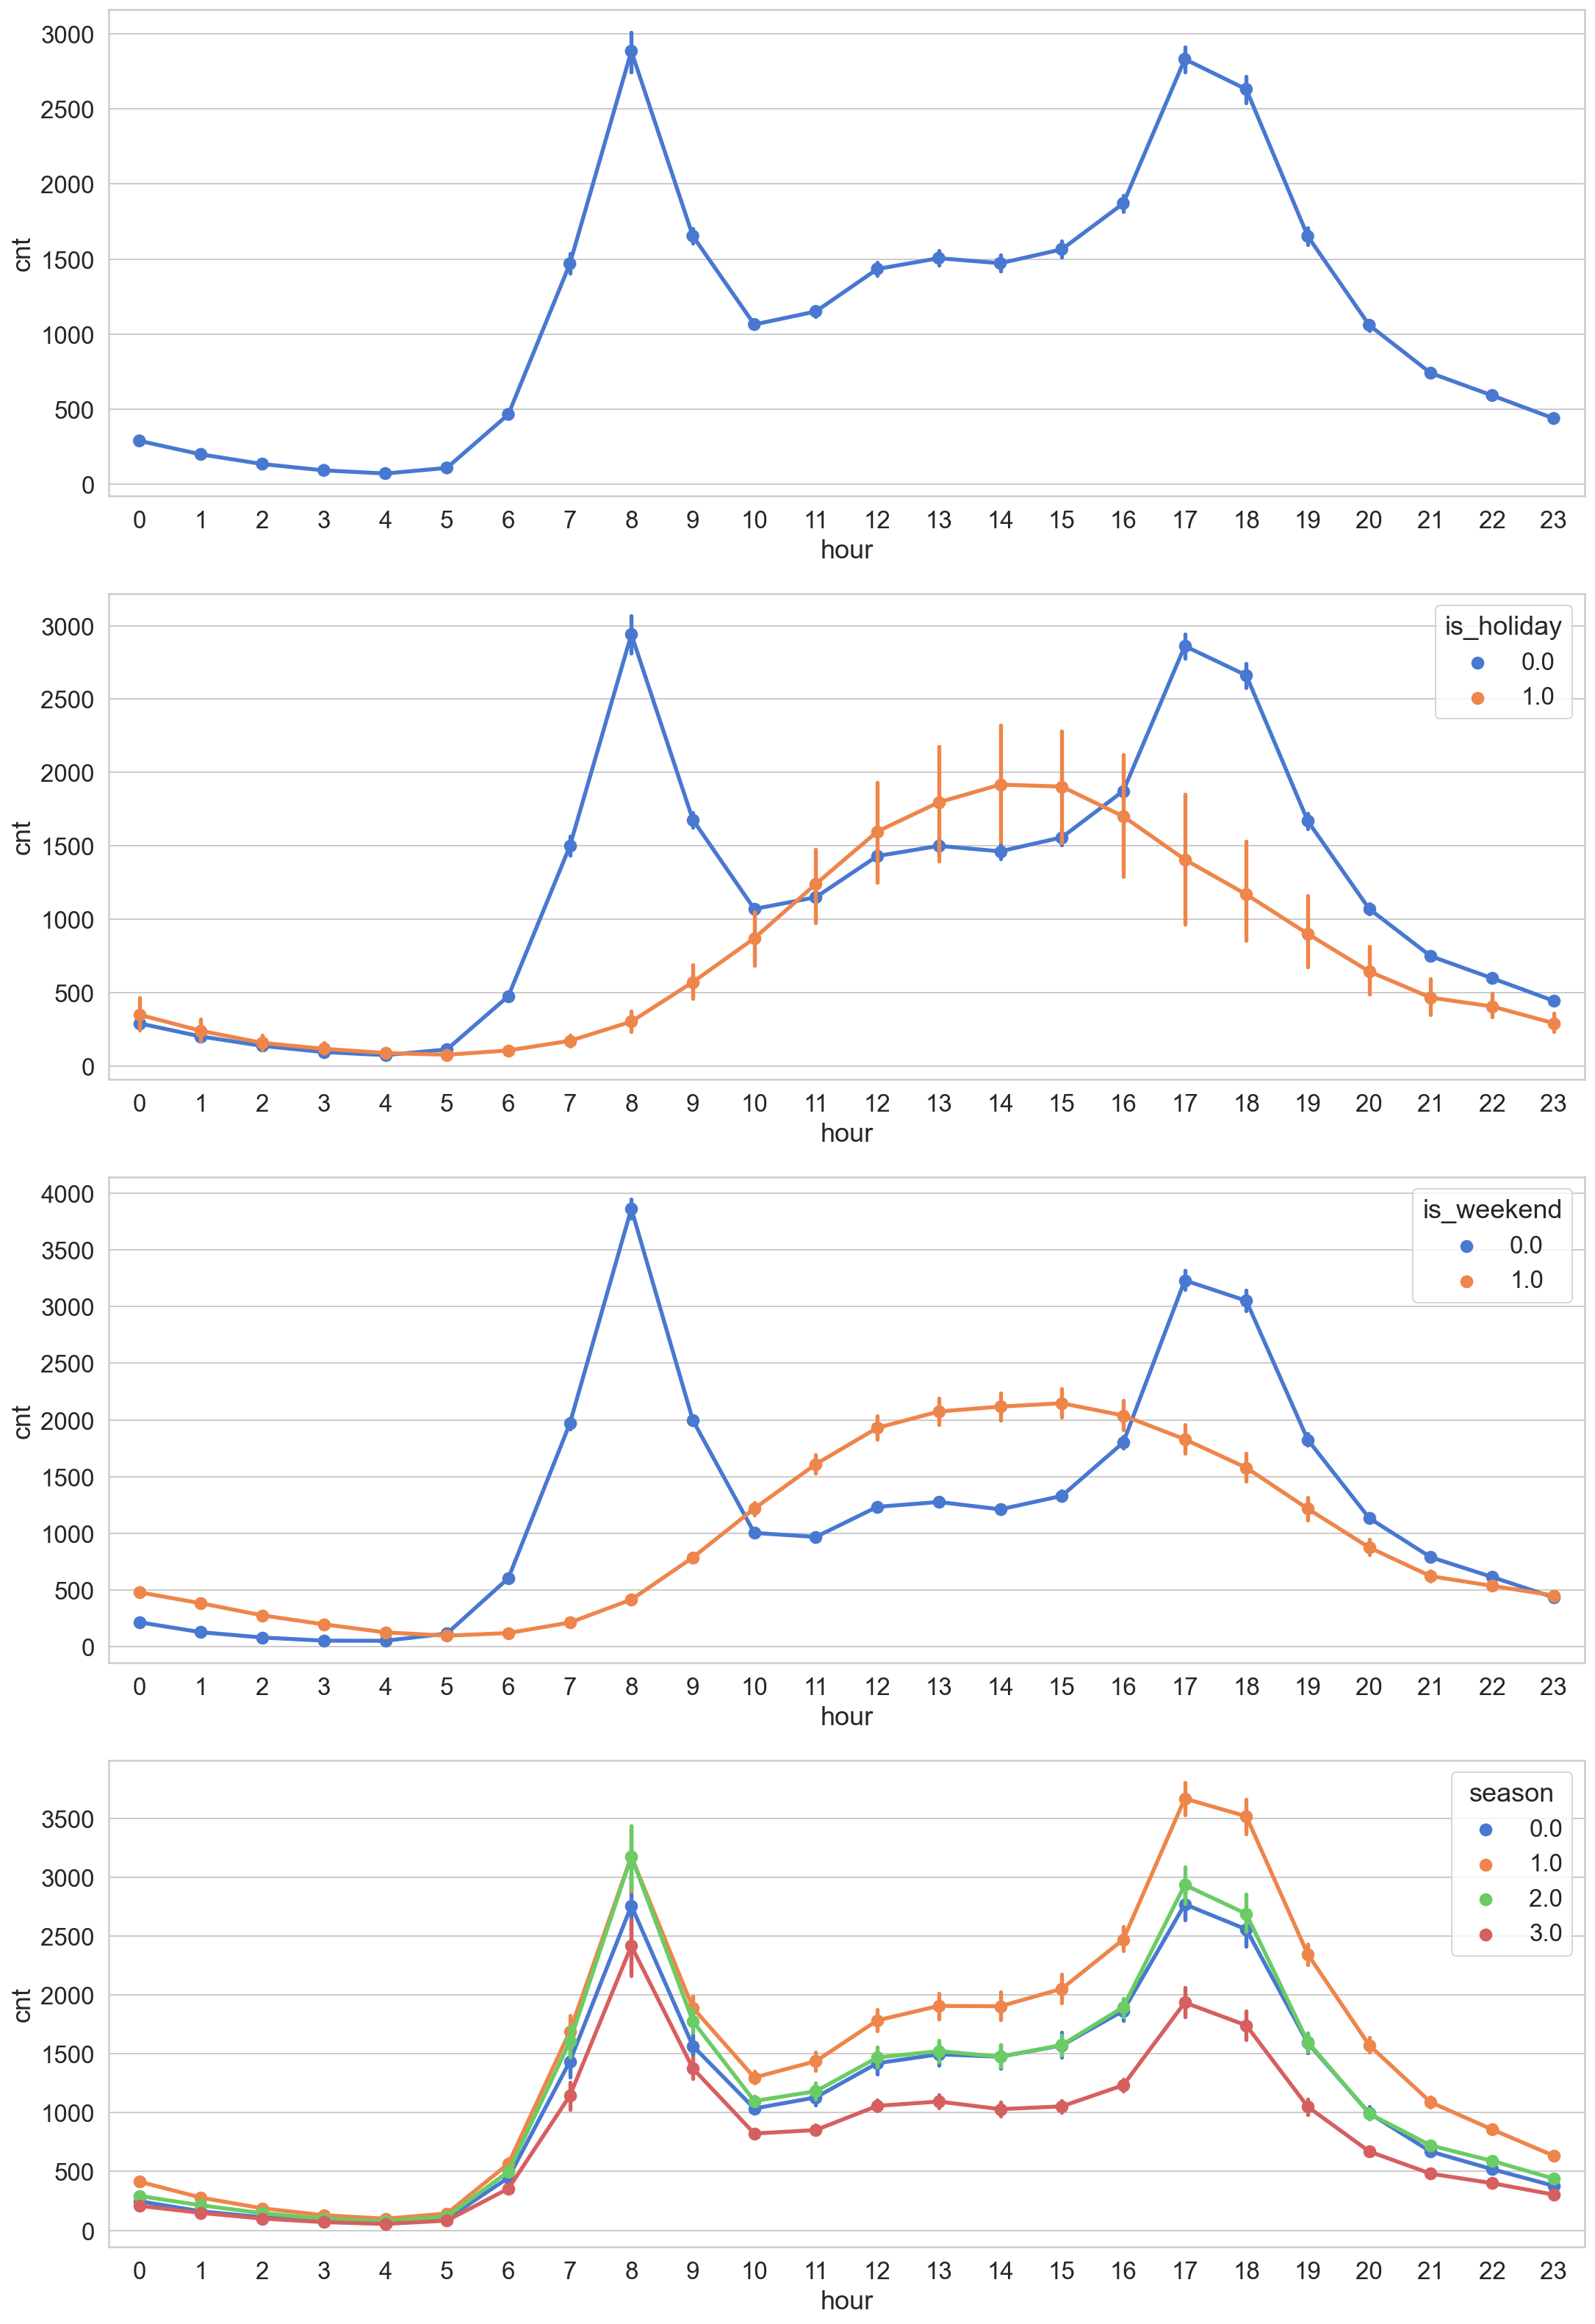

In [15]:
fig,(ax1, ax2, ax3, ax4)= plt.subplots(nrows=4)
fig.set_size_inches(18, 28)

sns.pointplot(data=df, x='hour', y='cnt', ax=ax1)
sns.pointplot(data=df, x='hour', y='cnt', hue='is_holiday', ax=ax2)
sns.pointplot(data=df, x='hour', y='cnt', hue='is_weekend', ax=ax3)
sns.pointplot(data=df, x='hour', y='cnt', hue='season', ax=ax4);

The hours with most bike shares differ significantly based on a weekend or not days. Workdays contain two large spikes during the morning and late afternoon hours (people pretend to work in between). On weekends early to late afternoon hours seem to be the busiest.

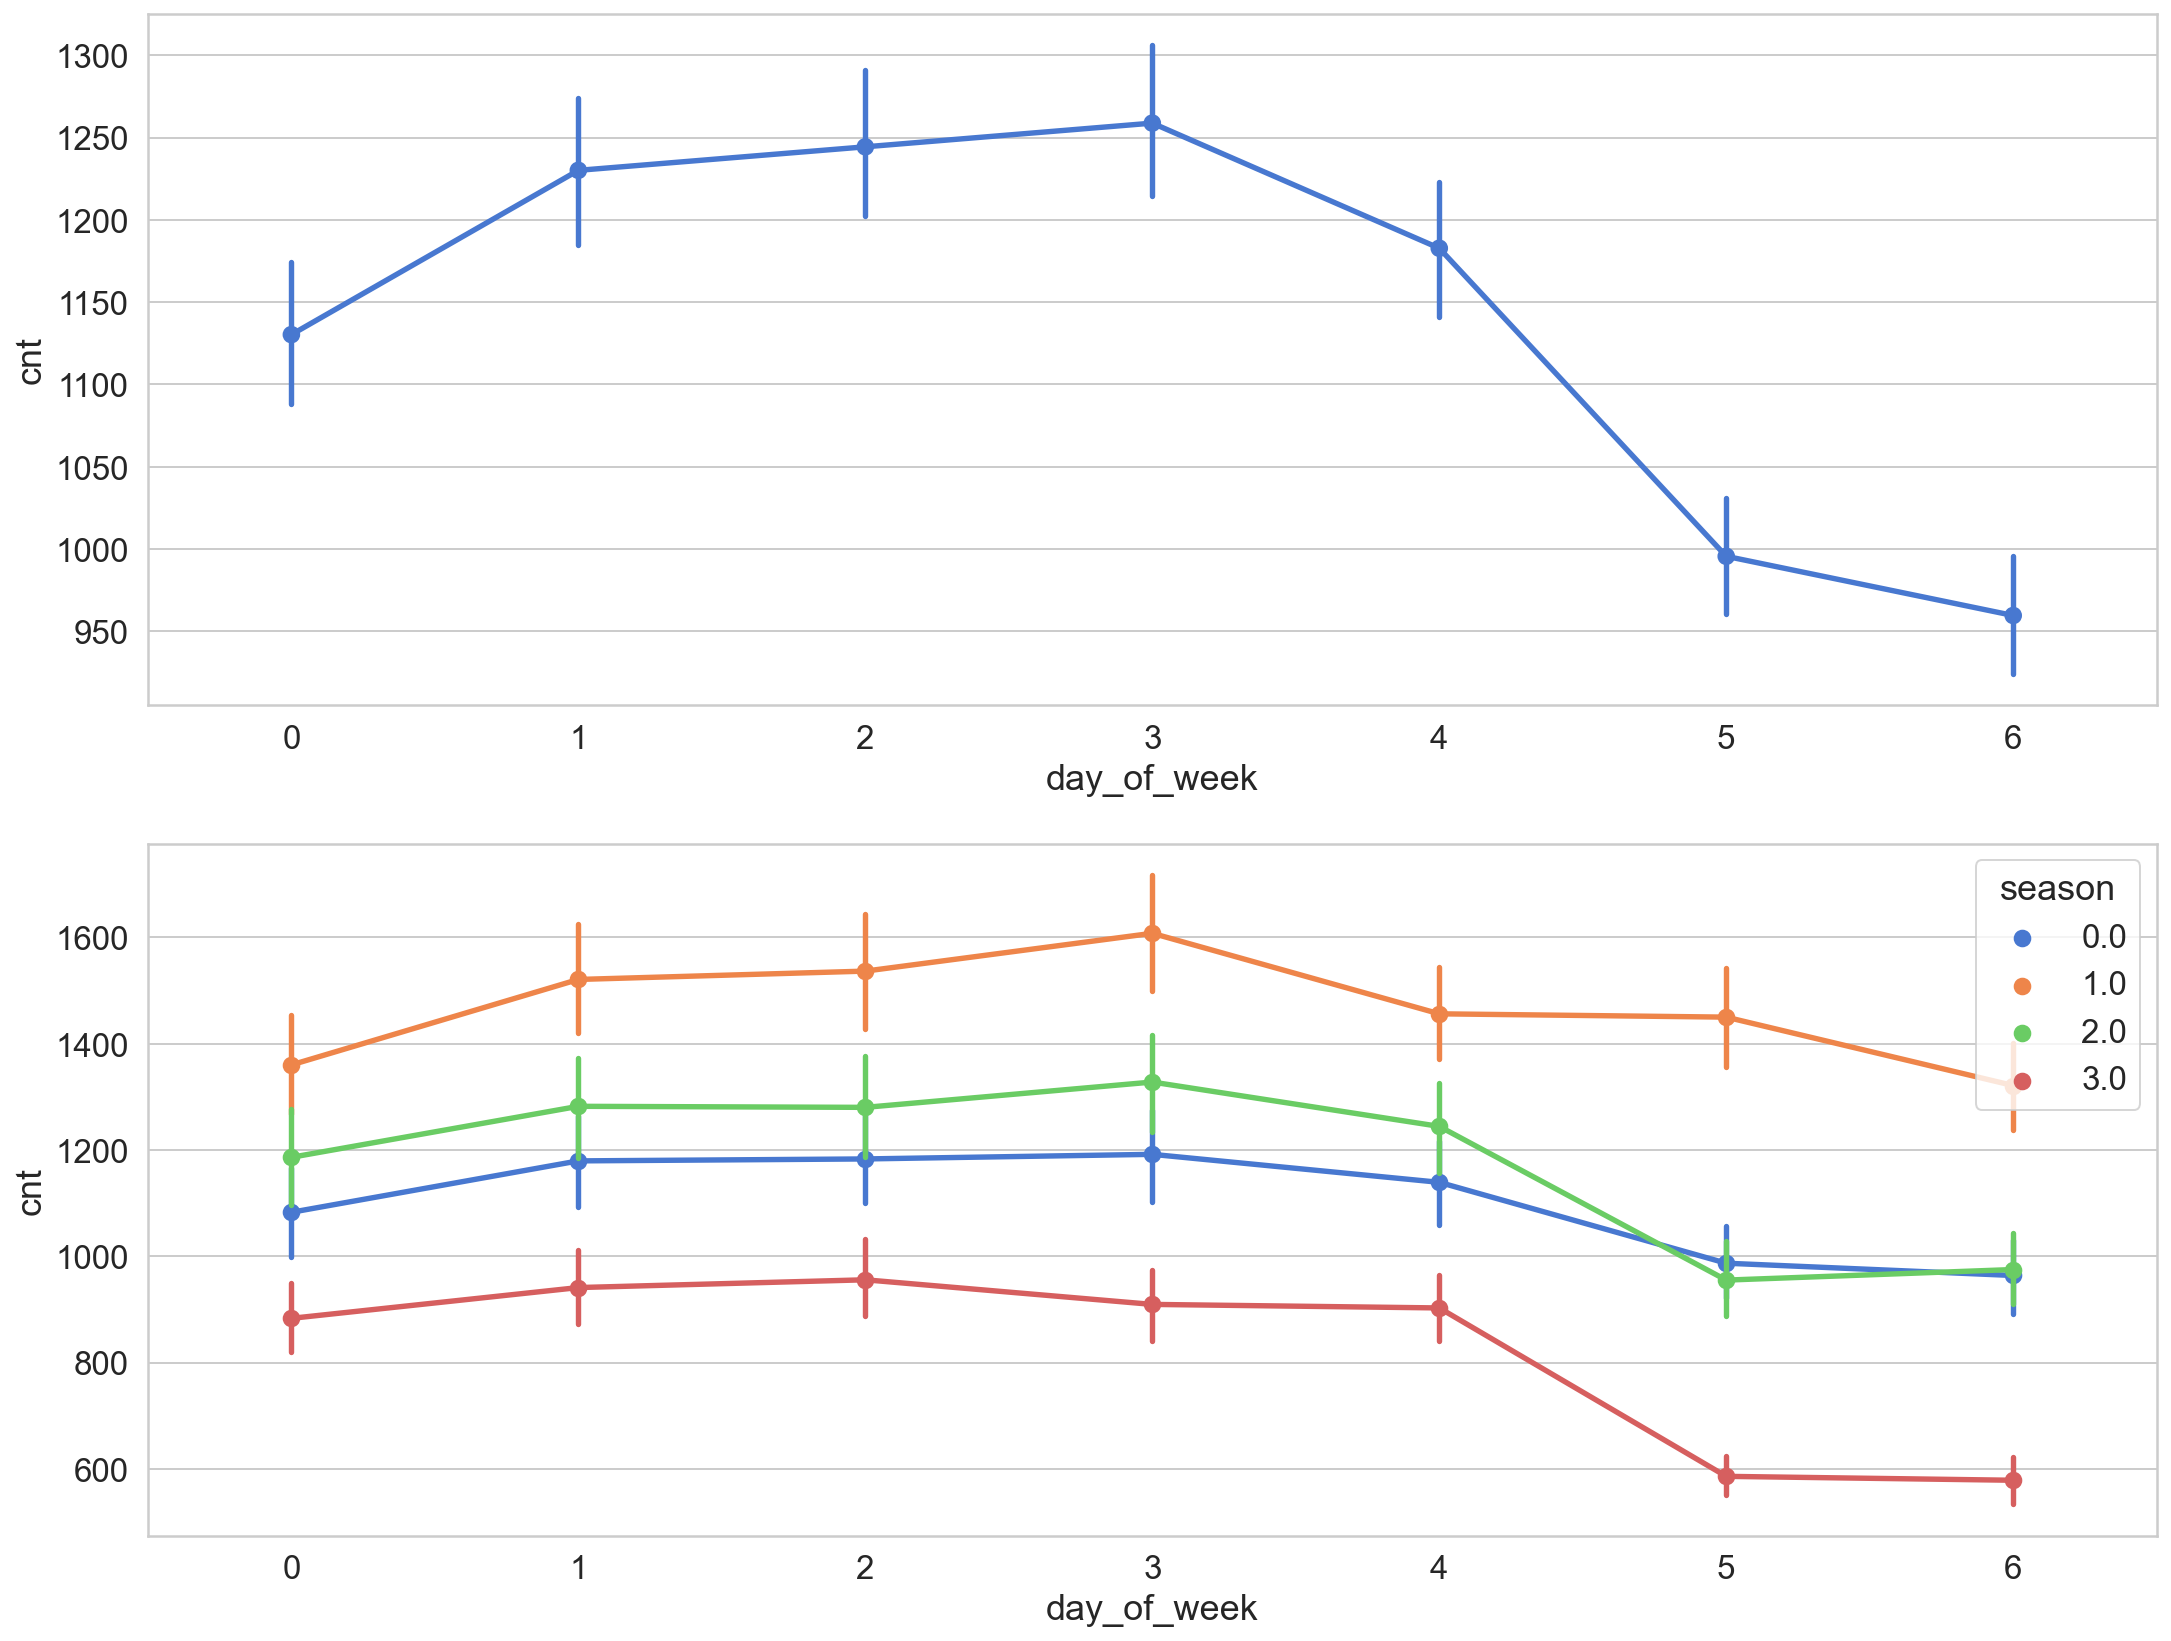

In [16]:
fig,(ax1, ax2)= plt.subplots(nrows=2)
fig.set_size_inches(18, 14)

sns.pointplot(data=df, x='day_of_week', y='cnt', ax=ax1)
sns.pointplot(data=df, x='day_of_week', y='cnt', hue='season', ax=ax2);

Looking at the data by day of the week shows a much higher count on the number of bike shares.

Our little feature engineering efforts seem to be paying off. The new features separate the data very well.

# Preprocessing

In [26]:
train_size = int(len(df) * 0.9)
test_size = len(df) - train_size
train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]
print(len(train), len(test))

15672 1742


We’ll scale some of the features we’re using for our modeling:

In [29]:
from sklearn.preprocessing import RobustScaler

f_columns = ['t1', 't2', 'hum', 'wind_speed']

f_transformer = RobustScaler()
cnt_transformer = RobustScaler()

f_transformer = f_transformer.fit(train[f_columns].to_numpy())
cnt_transformer = cnt_transformer.fit(train[['cnt']])

train.loc[:, f_columns] = f_transformer.transform(train[f_columns].to_numpy())
train['cnt'] = cnt_transformer.transform(train[['cnt']])

test.loc[:, f_columns] = f_transformer.transform(test[f_columns].to_numpy())
test['cnt'] = cnt_transformer.transform(test[['cnt']])

C:\Users\Data Scientist\AppData\Roaming\Python\Python38\site-packages\pandas\core\indexing.py:1835: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\DATASC~1\AppData\Local\Temp/ipykernel_30580/2674891756.py:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Data Scientist\AppData\Roaming\Python\Python38\site-packages\pandas\core\indexing.py:1835: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead


To prepare the sequences, we’re going to reuse the same `create_dataset()` function:



In [30]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)        
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

Each sequence is going to contain 10 data points from the history:



In [31]:
time_steps = 10

# reshape to [samples, time_steps, n_features]

X_train, y_train = create_dataset(train, train.cnt, time_steps)
X_test, y_test = create_dataset(test, test.cnt, time_steps)

print(X_train.shape, y_train.shape)

(15662, 10, 13) (15662,)


# Predicting Demand


In [32]:
model = keras.Sequential()
model.add(
  keras.layers.Bidirectional(
    keras.layers.LSTM(
      units=128, 
      input_shape=(X_train.shape[1], X_train.shape[2])
    )
  )
)
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.Dense(units=1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [33]:
history = model.fit(
    X_train, y_train, 
    epochs=30, 
    batch_size=32, 
    validation_split=0.1,
    shuffle=False
)

Epoch 1/30
441/441 [==============================] - 11s 10ms/step - loss: 0.3270 - val_loss: 0.1255
Epoch 2/30
441/441 [==============================] - 4s 8ms/step - loss: 0.0818 - val_loss: 0.0660
Epoch 3/30
441/441 [==============================] - 4s 9ms/step - loss: 0.0511 - val_loss: 0.0537
Epoch 4/30
441/441 [==============================] - 4s 8ms/step - loss: 0.0389 - val_loss: 0.0358
Epoch 5/30
441/441 [==============================] - 4s 8ms/step - loss: 0.0307 - val_loss: 0.0317
Epoch 6/30
441/441 [==============================] - 4s 8ms/step - loss: 0.0276 - val_loss: 0.0307
Epoch 7/30
441/441 [==============================] - 4s 8ms/step - loss: 0.0271 - val_loss: 0.0317
Epoch 8/30
441/441 [==============================] - 4s 8ms/step - loss: 0.0239 - val_loss: 0.0306
Epoch 9/30
441/441 [==============================] - 4s 8ms/step - loss: 0.0235 - val_loss: 0.0318
Epoch 10/30
441/441 [==============================] - 4s 8ms/step - loss: 0.0218 - val_loss: 0.03

# Evaluation

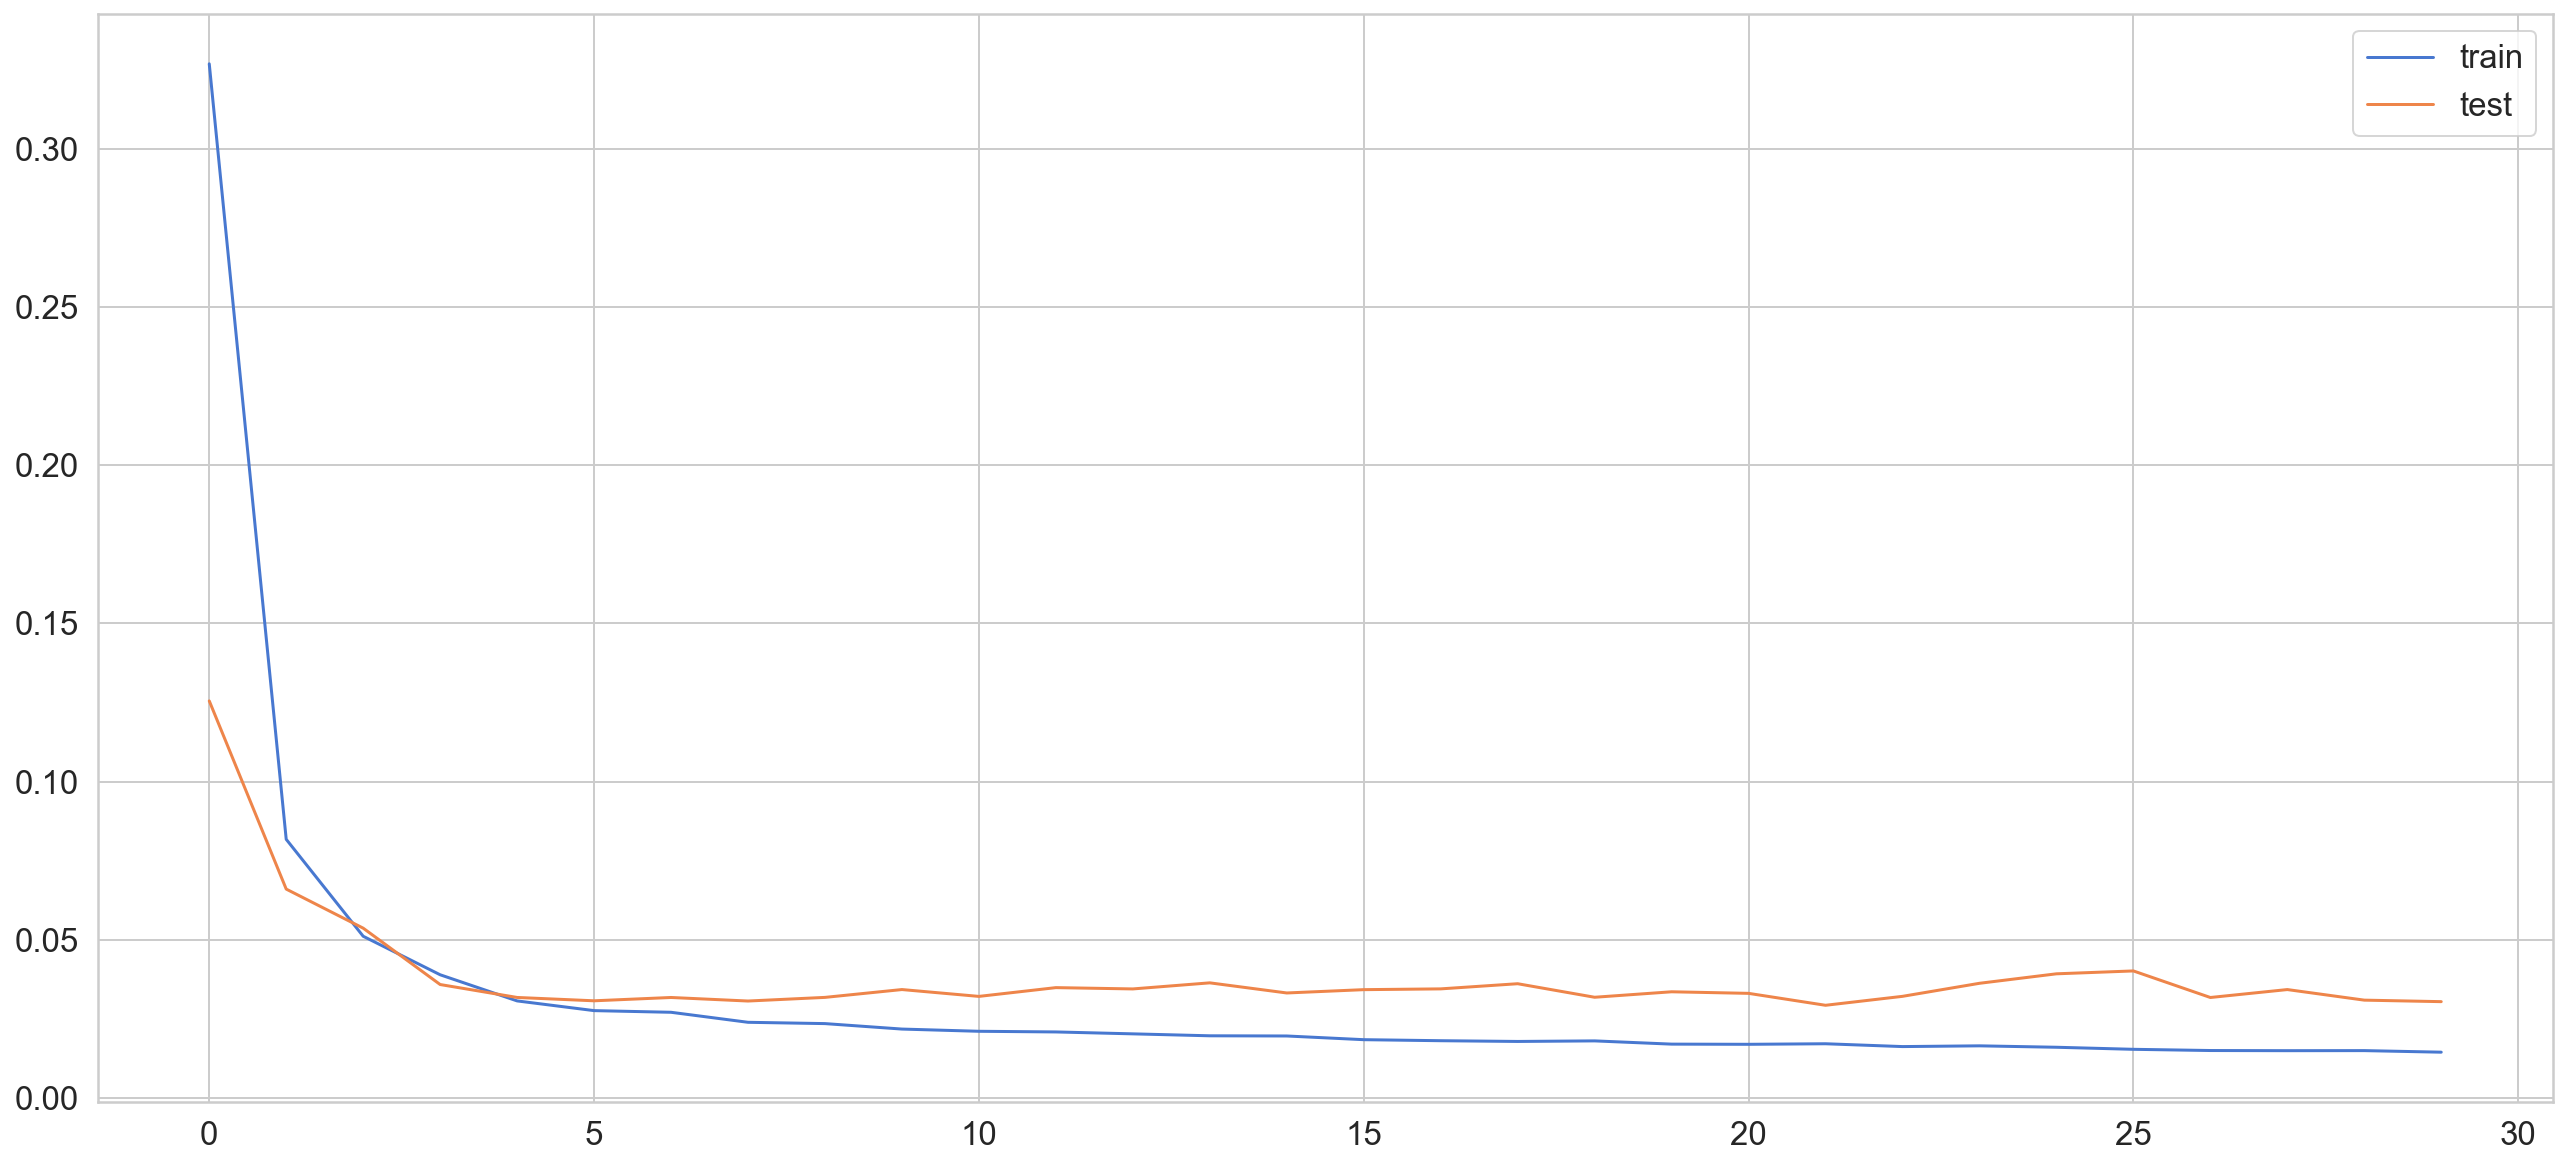

In [34]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend();

You can see that the model learns pretty quickly. At about epoch 5, it is already starting to overfit a bit. You can play around - regularize it, change the number of units, etc. But how well can we predict demand with it?

In [35]:
y_pred = model.predict(X_test)


In [36]:
y_train_inv = cnt_transformer.inverse_transform(y_train.reshape(1, -1))
y_test_inv = cnt_transformer.inverse_transform(y_test.reshape(1, -1))
y_pred_inv = cnt_transformer.inverse_transform(y_pred)

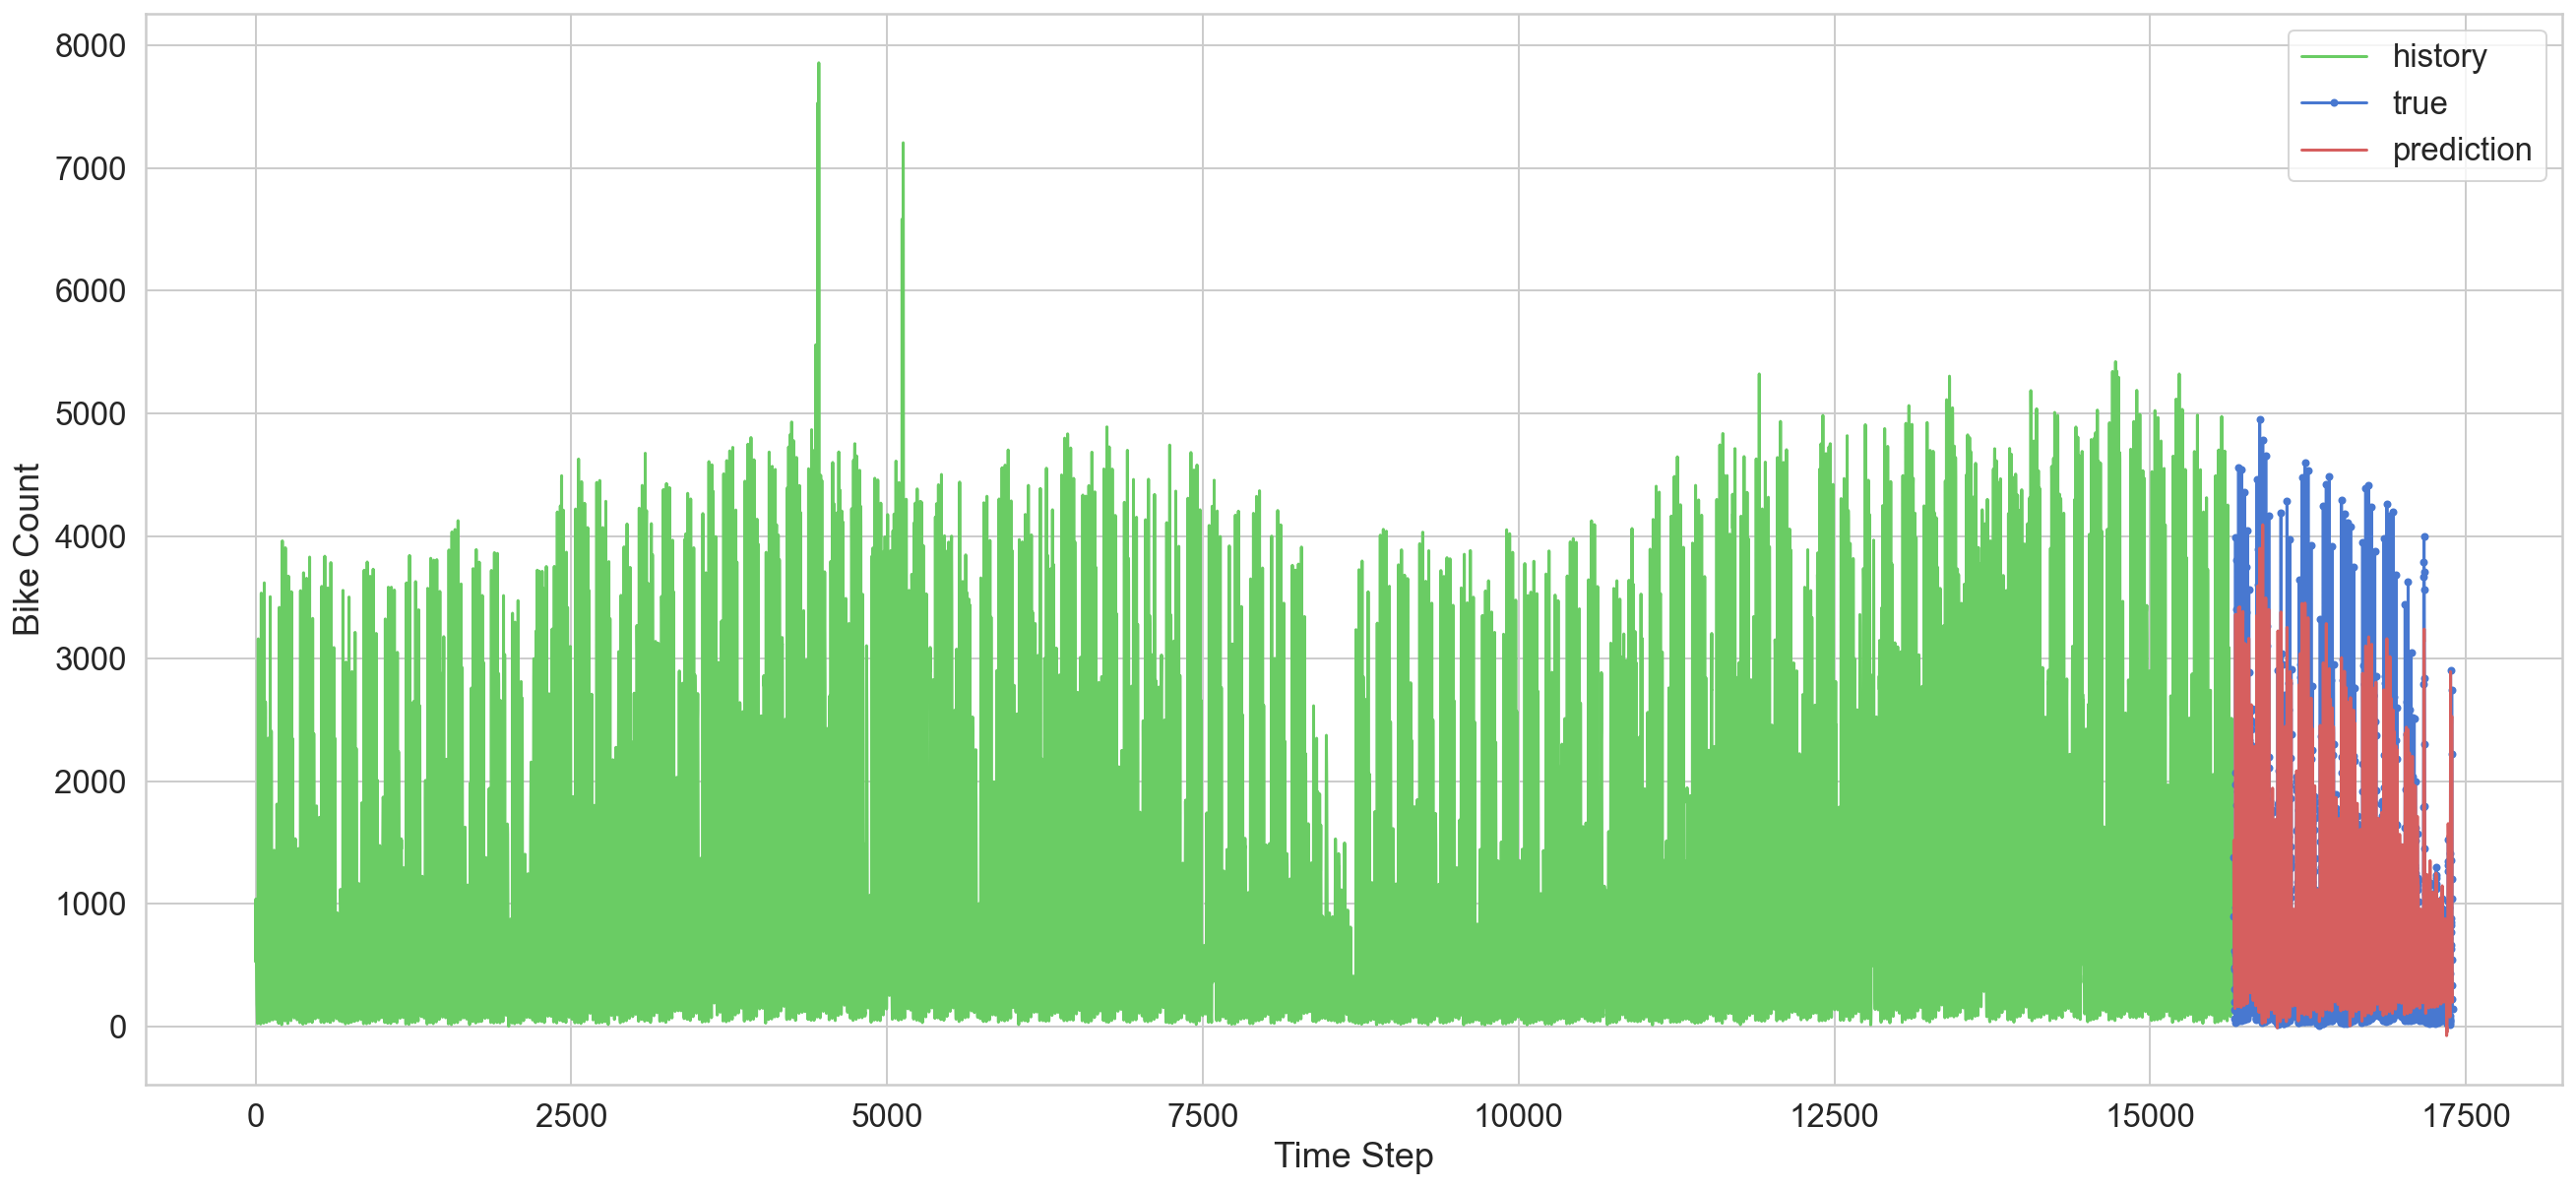

In [37]:
plt.plot(np.arange(0, len(y_train)), y_train_inv.flatten(), 'g', label="history")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test_inv.flatten(), marker='.', label="true")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_pred_inv.flatten(), 'r', label="prediction")
plt.ylabel('Bike Count')
plt.xlabel('Time Step')
plt.legend()
plt.show();

In [39]:
That might be too much for your eyes. Let’s zoom in on the predictions:



SyntaxError: invalid syntax (Temp/ipykernel_30580/1987713741.py, line 1)

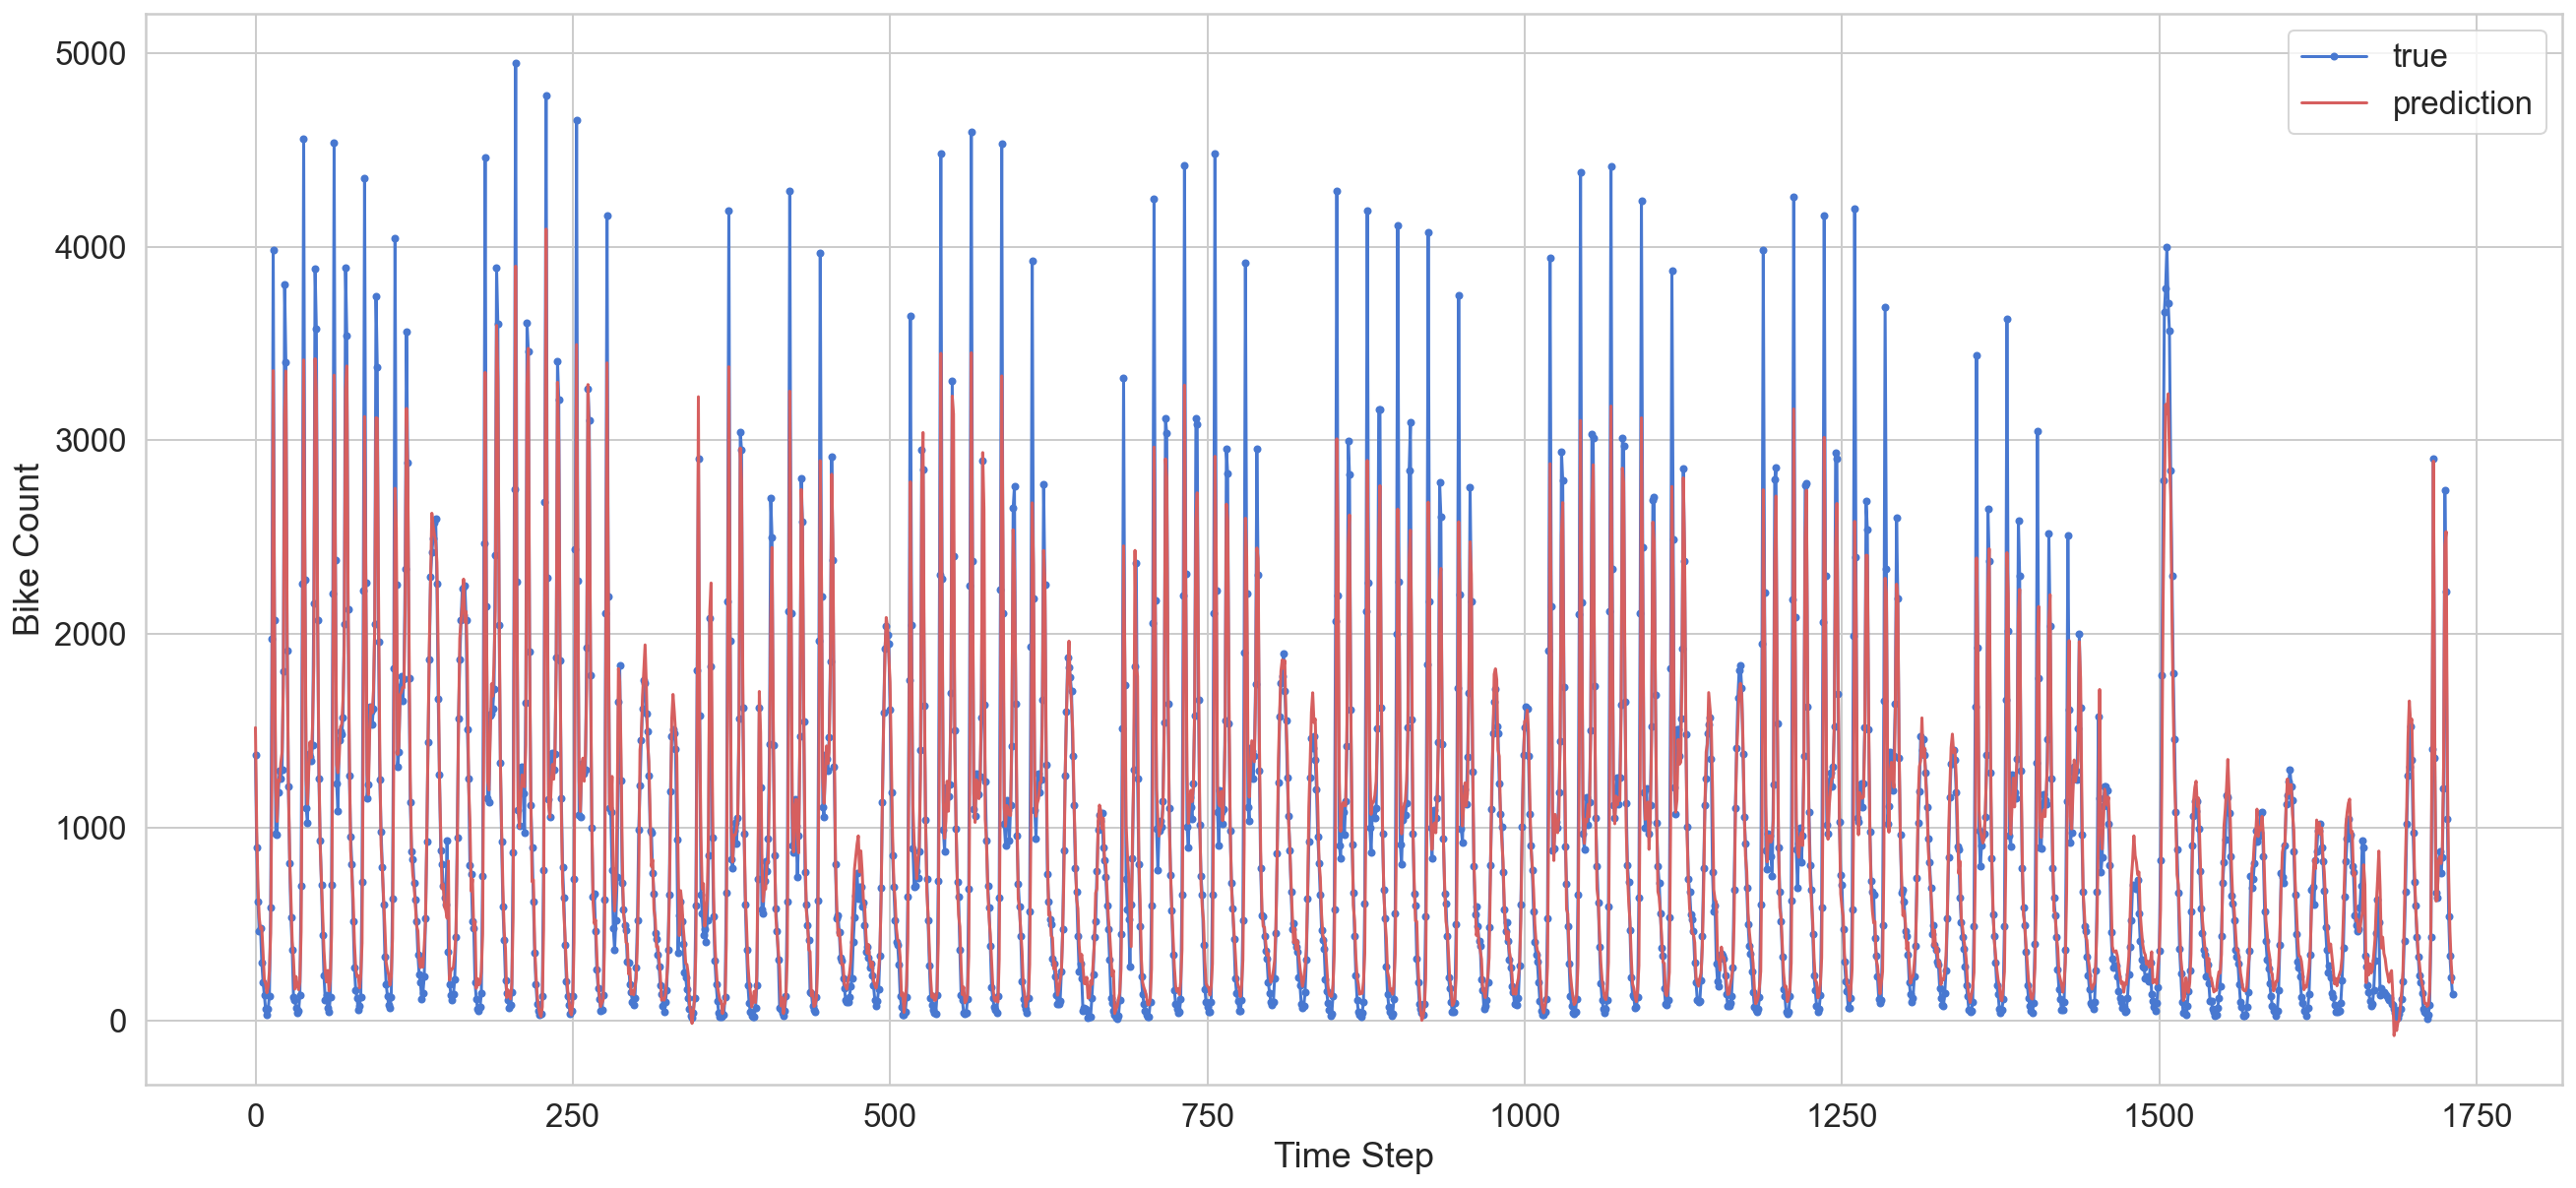

In [38]:
plt.plot(y_test_inv.flatten(), marker='.', label="true")
plt.plot(y_pred_inv.flatten(), 'r', label="prediction")
plt.ylabel('Bike Count')
plt.xlabel('Time Step')
plt.legend()
plt.show();

Note that our model is predicting only one point in the future. That being said, it is doing very well. Although our model can’t really capture the extreme values it does a good job of predicting (understanding) the general pattern.

